In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy
#import slycot
import matplotlib.pyplot as plt
from neurosim.models.ssr import StateSpaceRealization as SSR

In [3]:
import pickle
import sys

In [4]:
sys.path.append('../..')

In [5]:
from riccati import check_gdare, solve_gdare

### Positive Realness debugging

In [7]:
with open('test_case3.dat', 'rb') as f:
    varlist = pickle.load(f)
A, C, Cbar, L0 = varlist

In [26]:
check_gdare(A, C, Cbar, L0, tol=1e-2)

True

In [13]:
# Compare solutions of scipy's solve_discrete_are with slycot solver
# Also try implementations of square root filters

In [27]:
Pinf1 = scipy.linalg.solve_discrete_are(A.T, C.T, np.zeros(A.shape), L0, s=Cbar.T)

In [28]:
np.linalg.eigvals(Pinf1)

array([ 1.99953651, -0.78987346, -0.54351242, -0.4711019 ,  0.0407459 ,
       -0.36933667, -0.01314757, -0.02687123, -0.03116439, -0.09048765,
       -0.32908127, -0.12197568, -0.28704822, -0.26301037, -0.22132354,
       -0.18238889, -0.19533339])

In [42]:
Pinf2, rcond, w, S, T = slycot.synthesis.sb02od(A.shape[0], C.shape[0], -A.T, C.T, Q=np.zeros(A.shape), R=-L0, dico='D', L=Cbar.T)

In [43]:
np.linalg.eigvals(Pinf2)

array([-1.99953651,  0.78987346,  0.54351242,  0.4711019 , -0.0407459 ,
        0.36933667,  0.01314757,  0.02687123,  0.03116439,  0.09048765,
        0.32908127,  0.12197568,  0.28704822,  0.26301037,  0.22132354,
        0.18238889,  0.19533339])

In [27]:
# Directly implement...

In [31]:
AA, BB, alpha, beta, Q, Z = solve_gdare(A, C, Cbar, L0)

In [32]:
geig = np.abs(np.divide(alpha, beta))

In [33]:
iuc = np.where(np.abs(geig) < 1)[0]

In [35]:
U1 = Z[0:A.shape[0], iuc]
U2 = Z[A.shape[0]:, iuc]

In [36]:
Pinf3 = scipy.linalg.solve(U1.T, U2.T)

In [37]:
np.linalg.eigvals(Pinf3)

array([ 1.10309849e+02,  1.32304383e+01, -3.51228231e+00,  5.05315906e+00,
        3.99121931e+00,  1.87774018e-02,  5.39526330e-01,  6.81320123e-01,
        2.36257337e+00,  2.31036455e+00,  2.05630755e+00,  1.18660739e+00,
        1.26179059e+00,  1.40930774e+00,  1.76403759e+00,  1.57378104e+00,
        1.62737429e+00])

In [59]:
# Does it solve the Riccati equation?
from riccati import discrete_generalized_riccati, discrete_riccati

In [44]:
np.linalg.norm(Pinf2 - discrete_generalized_riccati(Pinf2, A, C, Cbar, L0))

2.636863275618374e-14

In [46]:
np.linalg.eigvals(Pinf2)

array([-1.99953651,  0.78987346,  0.54351242,  0.4711019 , -0.0407459 ,
        0.36933667,  0.01314757,  0.02687123,  0.03116439,  0.09048765,
        0.32908127,  0.12197568,  0.28704822,  0.26301037,  0.22132354,
        0.18238889,  0.19533339])

In [47]:
np.linalg.eigvals(L0 - C @ Pinf2 @ C.T)

array([ 4.74189932, -0.26476504,  1.80749544,  1.5401542 ,  0.62185488,
        0.71584091,  0.9188448 ,  1.12751044,  1.01783403,  1.07531563])

In [50]:
np.linalg.pinv(L0 - C @ Pinf2 @ C.T)

array([[-0.41109591,  0.7170694 , -1.68620944,  0.34748773,  0.17251269,
         0.07022032, -0.19105052,  1.377519  ,  0.23344722,  0.39175148],
       [ 0.7170694 ,  0.64037057,  0.43723568, -0.1844536 , -0.04152925,
         0.16914235,  0.30652485, -0.82333773, -0.21327981, -0.24290065],
       [-1.68620944,  0.43723568, -0.17101315,  0.4087879 ,  0.09318001,
        -0.3249468 ,  0.02775428,  1.12407058,  0.09478938,  0.45936201],
       [ 0.34748773, -0.1844536 ,  0.4087879 ,  0.79898573, -0.01772761,
         0.23043358,  0.01909752, -0.49220315, -0.0620754 , -0.09592097],
       [ 0.17251269, -0.04152925,  0.09318001, -0.01772761,  0.91950066,
        -0.10641036, -0.01099426, -0.02747409,  0.05647644, -0.02867474],
       [ 0.07022032,  0.16914235, -0.3249468 ,  0.23043358, -0.10641036,
         0.88667452,  0.02283101, -0.08276278, -0.09273402, -0.02531967],
       [-0.19105052,  0.30652485,  0.02775428,  0.01909752, -0.01099426,
         0.02283101,  0.50859417,  0.35598724

In [30]:
from subspaces import estimate_autocorrelation, SubspaceIdentification, IteratedStableEstimator

In [86]:
iter = 0
# Checking for failure of PSD of the riccati soliution
while True:
    state_dim = 20
    obs_dim = 10
    A = np.random.normal(scale=1/(1.7 * np.sqrt(state_dim)), size=(state_dim, state_dim))
    while max(np.abs(np.linalg.eigvals(A))) > 0.99:
        A = np.random.normal(scale=1/(1.7 * np.sqrt(state_dim)), size=(state_dim, state_dim))

    C = scipy.stats.ortho_group.rvs(state_dim)[:, 0:obs_dim].T
    ssr = SSR(A=A, B=np.eye(A.shape[0]), C=C)
    ccm0 = ssr.autocorrelation(5)
    y = ssr.trajectory(int(1e3))
    ccm1 = estimate_autocorrelation(y, 5)   
    ssid1 = SubspaceIdentification(T=3, estimator=IteratedStableEstimator, score='BIC', obs_regressor='OLS')
    _, _, _, _ = ssid1.identify(y)
    # Pinf = scipy.linalg.solve_discrete_are(A.T, C.T, Q, R, s=S)
    # eig = np.linalg.eigvals(Pinf)
    # eig = np.linalg.eigvals(PInf)
    # if np.any(eig < 0):
    #     print('Non PSD P found!')
    #     break
    # L0 = 0.5 * (L0 + L0.T)
    # Pinf2 = scipy.linalg.solve_discrete_are(A.T, -C.T, np.zeros(A.shape), -L0, s=Cbar.T)
    # eig = np.linalg.eigvals(Pinf)
    # if np.any(eig < 0):
    #     print('Non PSD P- found!')
    #     break

    iter += 1
    print(iter)


True
True
True
True
True
pr correction employed
True
pr correction employed
True
pr correction employed
True
pr correction employed
True
> /home/akumar/nse/neural_control/subspaces.py(197)filter_log_likelihood()
    195             pdb.set_trace()
    196 
--> 197         if np.any(np.isinf(P)) or np.any(np.isnan(P)):
    198             pdb.set_trace()
    199 



BdbQuit: 

In [ ]:
# So we always get a positive definite solution to the Riccati equation. They key is then finding a stable iteration th at converges to this solution

In [ ]:
# Can we code up a test of the necessary/sufficient conditions for convergence provided by Kailath?

In [66]:
import pickle

In [76]:
with open('test_case5.dat', 'rb') as f:
    varlist = pickle.load(f)
    A, C, Q, R, S, Pinf = varlist

In [82]:
np.linalg.eigvals(Pinf)

array([2.27246925, 1.91094207, 1.60917569, 1.50984817, 1.2329283 ,
       1.07455583, 0.89707979, 0.15340883, 0.24352311, 0.26783781,
       0.31939546, 0.38168371, 0.71585725, 0.71223314, 0.44590874,
       0.47804822, 0.51379959, 0.5465913 , 0.64529787, 0.62706115])

In [77]:
np.linalg.eigvals(R)

array([9.32021859e-01, 5.51274788e-01, 3.09405093e-01, 1.68205128e-01,
       9.09957396e-02, 3.01910013e-02, 2.42523470e-02, 1.90557441e-02,
       1.81358557e-04, 1.03698400e-03])

In [79]:
np.linalg.eigvals(Q)

array([1.01447406, 0.91623909, 0.82377518, 0.79935936, 0.73927198,
       0.715388  , 0.65455949, 0.04751026, 0.57177943, 0.51679994,
       0.46731078, 0.44385444, 0.38317171, 0.33108076, 0.30190755,
       0.12495745, 0.14824874, 0.23030189, 0.19921325, 0.1769245 ])

In [81]:
np.linalg.eigvals(np.block([[Q, S], [S.T, R]]))

array([1.06800411e+00, 9.72457336e-01, 8.91357265e-01, 8.18361982e-01,
       8.04883566e-01, 7.58610946e-01, 7.22720929e-01, 6.99842394e-01,
       5.69737266e-01, 5.38708309e-01, 4.96664859e-01, 4.64851776e-01,
       4.35651556e-01, 4.02190707e-01, 3.60295511e-01, 3.15863940e-01,
       2.89882666e-01, 2.30400092e-01, 2.11993224e-01, 1.76432054e-01,
       1.33698041e-01, 1.12728400e-01, 8.63145118e-02, 6.63591892e-02,
       4.55749125e-02, 7.84944446e-04, 1.30081639e-04, 1.36688720e-02,
       2.52717781e-02, 1.93066562e-02])

In [83]:
# Check unit circle controllability
Fs = A - S @ np.linalg.inv(R) @ C

In [85]:
np.abs(np.linalg.eigvals(Fs))

array([2.83721894, 2.83721894, 1.93052056, 1.82502613, 1.09348154,
       1.09348154, 1.02699262, 1.02699262, 0.98720627, 0.98720627,
       1.07006834, 1.07006834, 1.15059438, 0.55515037, 0.55515037,
       0.51907198, 0.51907198, 0.76467797, 0.76467797, 0.56455857])

In [84]:
# Try solving the error Riccati equation
norm_diff = []

Q = Pl

for i in range(1000):
    Q_ = discrete_riccati(Q, A, B, C, L0, S=D.T)
    norm_diff.append(np.linalg.norm(Q - Q_))
    Q = Q_

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 10 is different from 13)

### Use the pykalman filter/smoother

In [6]:
from pykalman.sqrt.cholesky import CholeskyKalmanFilter
from pykalman import KalmanFilter

In [ ]:
# Wrapper around pykalman's Kalman Filter to enable correlations between the noises
# This requires R > 0 (see Kailath 9.5.1)
class KalmanFilterWrapper(KalmanFilter):
    def __init__(self, A, C, Q, R, S, initial_state_mean=None, initial_state_covariance=None, random_state=None):

        # Modify A and Q to include S
        A = A - S @ np.linalg.inv(R) @ C
        Q = Q - S @ np.linalg.inv(R) @ S.T


    def filter():



### Test ML inference

In [8]:
from em import StableStateSpaceML

In [9]:
state_dim = 20
obs_dim = 10
A = np.random.normal(scale=1/(1.7 * np.sqrt(state_dim)), size=(state_dim, state_dim))
while max(np.abs(np.linalg.eigvals(A))) > 0.99:
    A = np.random.normal(scale=1/(1.7 * np.sqrt(state_dim)), size=(state_dim, state_dim))

C = scipy.stats.ortho_group.rvs(state_dim)[:, 0:obs_dim].T
ssr = SSR(A=A, B=np.eye(A.shape[0]), C=C)

In [10]:
sssml = StableStateSpaceML()

In [11]:
y = ssr.trajectory(int(1e4))

In [16]:
sssml.fit(y, state_dim=20)

Riccati check: True
Iteration 1, Log Likelihood: -192870.298289


../../em.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  Psqrt_pred[i] = Psqrt_pred_
../../em.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  Ppred[i] = Psqrt_pred_ @ Psqrt_pred_.T
../../em.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  Psqrt_filt[i] = Psqrt_filt_
../../em.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  Psmooth[i] = Psqrt_smooth @ Psqrt_smooth.T


Riccati check: True
Iteration 2, Log Likelihood: -178162.904424


../../em.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  Psqrt_pred[i] = Psqrt_pred_
../../em.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  Ppred[i] = Psqrt_pred_ @ Psqrt_pred_.T
../../em.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  Psqrt_filt[i] = Psqrt_filt_
../../em.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  Psmooth[i] = Psqrt_smooth @ Psqrt_smooth.T


Riccati check: True
Iteration 3, Log Likelihood: -176144.652870


../../em.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  Psqrt_pred[i] = Psqrt_pred_
../../em.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  Ppred[i] = Psqrt_pred_ @ Psqrt_pred_.T
../../em.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  Psqrt_filt[i] = Psqrt_filt_
../../em.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  Psmooth[i] = Psqrt_smooth @ Psqrt_smooth.T


Riccati check: True
Iteration 4, Log Likelihood: -174460.987268


../../em.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  Psqrt_pred[i] = Psqrt_pred_
../../em.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  Ppred[i] = Psqrt_pred_ @ Psqrt_pred_.T
../../em.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  Psqrt_filt[i] = Psqrt_filt_
../../em.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  Psmooth[i] = Psqrt_smooth @ Psqrt_smooth.T


Riccati check: True
Iteration 5, Log Likelihood: -173087.102195


../../em.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  Psqrt_pred[i] = Psqrt_pred_
../../em.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  Ppred[i] = Psqrt_pred_ @ Psqrt_pred_.T
../../em.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  Psqrt_filt[i] = Psqrt_filt_
../../em.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  Psmooth[i] = Psqrt_smooth @ Psqrt_smooth.T


Riccati check: True
Iteration 6, Log Likelihood: -171975.274086


../../em.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  Psqrt_pred[i] = Psqrt_pred_
../../em.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  Ppred[i] = Psqrt_pred_ @ Psqrt_pred_.T
../../em.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  Psqrt_filt[i] = Psqrt_filt_
../../em.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  Psmooth[i] = Psqrt_smooth @ Psqrt_smooth.T


Riccati check: True
Iteration 7, Log Likelihood: -171068.686875


../../em.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  Psqrt_pred[i] = Psqrt_pred_
../../em.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  Ppred[i] = Psqrt_pred_ @ Psqrt_pred_.T
../../em.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  Psqrt_filt[i] = Psqrt_filt_
../../em.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  Psmooth[i] = Psqrt_smooth @ Psqrt_smooth.T


Riccati check: True
Iteration 8, Log Likelihood: -170314.451319


../../em.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  Psqrt_pred[i] = Psqrt_pred_
../../em.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  Ppred[i] = Psqrt_pred_ @ Psqrt_pred_.T
../../em.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  Psqrt_filt[i] = Psqrt_filt_
../../em.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  Psmooth[i] = Psqrt_smooth @ Psqrt_smooth.T


Riccati check: True
Iteration 9, Log Likelihood: -169670.523004


../../em.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  Psqrt_pred[i] = Psqrt_pred_
../../em.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  Ppred[i] = Psqrt_pred_ @ Psqrt_pred_.T
../../em.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  Psqrt_filt[i] = Psqrt_filt_
../../em.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  Psmooth[i] = Psqrt_smooth @ Psqrt_smooth.T


Riccati check: True
Iteration 10, Log Likelihood: -169106.683860


../../em.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  Psqrt_pred[i] = Psqrt_pred_
../../em.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  Ppred[i] = Psqrt_pred_ @ Psqrt_pred_.T
../../em.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  Psqrt_filt[i] = Psqrt_filt_
../../em.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  Psmooth[i] = Psqrt_smooth @ Psqrt_smooth.T


Riccati check: True
Iteration 11, Log Likelihood: -168602.409386


../../em.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  Psqrt_pred[i] = Psqrt_pred_
../../em.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  Ppred[i] = Psqrt_pred_ @ Psqrt_pred_.T
../../em.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  Psqrt_filt[i] = Psqrt_filt_
../../em.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  Psmooth[i] = Psqrt_smooth @ Psqrt_smooth.T


Riccati check: True
Iteration 12, Log Likelihood: -168144.049306


../../em.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  Psqrt_pred[i] = Psqrt_pred_
../../em.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  Ppred[i] = Psqrt_pred_ @ Psqrt_pred_.T
../../em.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  Psqrt_filt[i] = Psqrt_filt_
../../em.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  Psmooth[i] = Psqrt_smooth @ Psqrt_smooth.T


Riccati check: True
Iteration 13, Log Likelihood: -167722.466110


../../em.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  Psqrt_pred[i] = Psqrt_pred_
../../em.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  Ppred[i] = Psqrt_pred_ @ Psqrt_pred_.T
../../em.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  Psqrt_filt[i] = Psqrt_filt_
../../em.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  Psmooth[i] = Psqrt_smooth @ Psqrt_smooth.T


Riccati check: True
Iteration 14, Log Likelihood: -167331.383208


../../em.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  Psqrt_pred[i] = Psqrt_pred_
../../em.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  Ppred[i] = Psqrt_pred_ @ Psqrt_pred_.T
../../em.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  Psqrt_filt[i] = Psqrt_filt_


KeyboardInterrupt: 

### Test square root filters/smoothers

In [261]:
from riccati import sqrt_filter, sqrt_smoother
from pykalman import KalmanFilter
from pykalman.standard import _filter, _smooth

In [286]:
# Compare results of sqrt_riccati to that of KalmanFilter
state_dim = 20
obs_dim = 10
A = np.random.normal(scale=1/(1.7 * np.sqrt(state_dim)), size=(state_dim, state_dim))
while max(np.abs(np.linalg.eigvals(A))) > 0.99:
    A = np.random.normal(scale=1/(1.7 * np.sqrt(state_dim)), size=(state_dim, state_dim))

C = scipy.stats.ortho_group.rvs(state_dim)[:, 0:obs_dim].T
ssr = SSR(A=A, B=np.eye(A.shape[0]), C=C)
ssr.solve_min_phase()

In [287]:
y = ssr.trajectory(int(1e3))

In [288]:
S = ssr.Bmin @ ssr.Dmin.T
R = 1.5 * ssr.Dmin @ ssr.Dmin.T
As = A - S @ np.linalg.inv(R) @ C
#Q = ssr.Bmin @ ssr.Bmin.T
Q = np.eye(A.shape[0])
Qs = Q - S @ np.linalg.inv(R) @ S.T
Qssqrt = scipy.linalg.sqrtm(Qs)

In [289]:
Pinf2 = scipy.linalg.solve_discrete_are((A - S @ np.linalg.inv(R) @ C).T, C.T, q=Qs, r=R)

In [290]:
Psqrt = np.eye(A.shape[0])
Pt_ = [Psqrt]
#Qsqrt = np.eye(A.shape[0])
Rsqrt = np.linalg.cholesky(R)
PP = np.eye(A.shape[0])
for i in range(1, y.shape[0]):
    Psqrt = sqrt_riccati(Psqrt, As, C, Qssqrt, Rsqrt)
    Pt_.append(Psqrt)
    PP = discrete_riccati(PP, A, C, Q, R, S=S)

In [291]:
np.linalg.norm(Pt_[-1] @ Pt_[-1].T - Pinf2)

1.4316127248683824e-14

In [292]:
(predicted_state_means, predicted_state_covariances,
            kalman_gains, filtered_state_means,
            filtered_state_covariances) = _filter(As, C, Qs, R, np.zeros(A.shape[0]), np.zeros(C.shape[0]), np.zeros(A.shape[0]), np.eye(A.shape[0]), y)

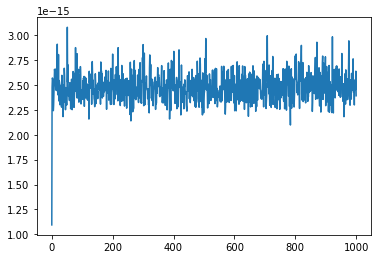

In [317]:
plt.plot([np.linalg.norm(kalman_gains[idx] - K[idx]) for idx in range(mupred.shape[0])])

In [326]:
(mufilt, mupred, Psqrt_filt, Psqrt_pred, Ppred, K, Re) = filter(y, A, C, Q, R, np.eye(A.shape[0]), np.zeros(A.shape[0]), S=S)

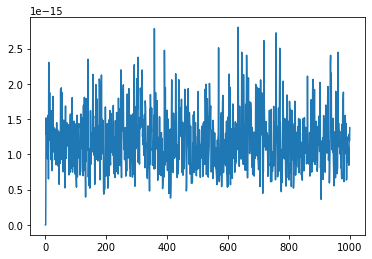

In [327]:
plt.plot([np.linalg.norm(predicted_state_means[idx] - mupred[idx]) for idx in range(mupred.shape[0])])

In [243]:
# There does not exist a square root smoother in pykalman

In [345]:
(smoothed_state_means, smoothed_state_covariances, kalman_smoothing_gains) = _smooth(As, filtered_state_means, 
                                                                                     filtered_state_covariances, predicted_state_means, 
                                                                                     predicted_state_covariances)

In [351]:
musmooth, Psmooth, Pfilt, J = smooth(y, A, C, Q, R, mufilt, mupred, Psqrt_filt, Psqrt_pred, Ppred, S=S) 

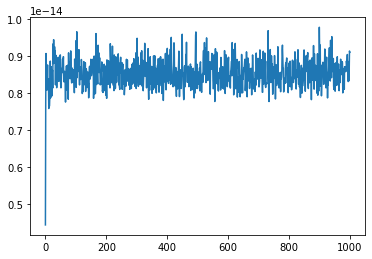

In [352]:
plt.plot([np.linalg.norm(smoothed_state_covariances[idx] - Psmooth[idx]) for idx in range(J.shape[0])])

In [308]:
# Smoother filtered state means, filtered state covariances, predicted state means, predicted state covariances

In [325]:
def filter(y, A, C, Q, R, P0, x0, S=None):

    # Run the square root Riccati recursion

    # Keep track of square root factors as they are needed by the smoother. Also assemble Re factors
    Psqrt_filt = np.zeros((y.shape[0],) + P0.shape)
    Psqrt_pred = np.zeros(Psqrt_filt.shape)
    Ppred = np.zeros(Psqrt_pred.shape)
    Re = np.zeros((y.shape[0], y.shape[1], y.shape[1]))    

    K = np.zeros((y.shape[0], P0.shape[0], y.shape[1]))
    mufilt = np.zeros((y.shape[0], P0.shape[0]))
    mupred = np.zeros((y.shape[0], P0.shape[0]))

    if S is not None:
        A = A - S @ np.linalg.inv(R) @ C
        Q = Q - S @ np.linalg.inv(R) @ S.T

    Psqrt_pred_ = np.linalg.cholesky(P0)
    Qsqrt = scipy.linalg.sqrtm(Q)
    Rsqrt = np.linalg.cholesky(R)

    x = x0
    for i in range(y.shape[0]):
        Psqrt_pred[i] = Psqrt_pred_
        Ppred[i] = Psqrt_pred_ @ Psqrt_pred_.T
        Re[i] = np.linalg.pinv(R + C @ Ppred[i] @ C.T)
        # Note this definition differs from the usual definition of Kalman gain (missing a factor of A), but 
        # is the one needed to accomplish separate filtering/prediction updates
        K[i] = Ppred[i] @ C.T @ Re[i]

        if i == 0:
            mupred[i] = x0
        else:
            mupred[i] = A @ mufilt[i - 1]

        # Incorporate new observation and step the prediction by 1
        Psqrt_pred_, Psqrt_filt_ = sqrt_filter(Psqrt_pred_, A, C, Qsqrt, Rsqrt)

        Psqrt_filt[i] = Psqrt_filt_              
        mufilt[i] = mupred[i] + K[i] @ (y[i] - C @ mupred[i])

    return mufilt, mupred, Psqrt_filt, Psqrt_pred, Ppred, K, Re

In [347]:
def smooth(y, A, C, Q, R, mufilt, mupred, Psqrt_filt, Psqrt_pred, Ppred, S=None):
    
    Psmooth = np.zeros(Psqrt_filt.shape)
    # In the process of calculating the smoothing covariances, we can assemble the filter covariances as well
    Pfilt = np.zeros(Psqrt_filt.shape)
    musmooth = np.zeros(mufilt.shape)
    J = np.zeros((Psqrt_filt.shape[0] - 1, Psqrt_filt.shape[1], mufilt.shape[1]))

    if S is not None:
        A = A - S @ np.linalg.inv(R) @ C
        Q = Q - S @ np.linalg.inv(R) @ S.T

    Pfilt[-1] = Psqrt_filt[-1] @ Psqrt_filt[-1].T
    Psmooth[-1] = Pfilt[-1]
    musmooth[-1] = mufilt[-1]

    Psqrt_smooth = np.linalg.cholesky(Psmooth[-1])
    Qsqrt = scipy.linalg.sqrtm(Q)
    for i in reversed(range(Psmooth.shape[0] - 1)):        
        Pfilt[i] = Psqrt_filt[i] @ Psqrt_filt[i].T
        J[i] = Pfilt[i] @ A.T @ np.linalg.pinv(Ppred[i + 1])  

        musmooth[i] = mufilt[i] + J[i] @ (musmooth[i + 1] - mupred[i + 1])
        Psqrt_smooth = sqrt_smoother(Psqrt_smooth, Psqrt_filt[i], A, Qsqrt, J[i])
        Psmooth[i] = Psqrt_smooth @ Psqrt_smooth.T

    return musmooth, Psmooth, Pfilt, J

### Test ARMA State Space Estimator

In [8]:
from em import ARMAStateSpaceML

In [9]:
state_dim = 20
obs_dim = 10
A = np.random.normal(scale=1/(1.7 * np.sqrt(state_dim)), size=(state_dim, state_dim))
while max(np.abs(np.linalg.eigvals(A))) > 0.99:
    A = np.random.normal(scale=1/(1.7 * np.sqrt(state_dim)), size=(state_dim, state_dim))

C = scipy.stats.ortho_group.rvs(state_dim)[:, 0:obs_dim].T
ssr = SSR(A=A, B=np.eye(A.shape[0]), C=C)

In [10]:
y = ssr.trajectory(int(1e4))

In [11]:
armamodel = ARMAStateSpaceML()

In [11]:
# Tasks
# (1) Test different optimizers in the M step optimization
# (2) Can we use stochastic gradient descent and only feed batches of observations? --> have to verify that this achieves lower cost on the entire time series
# (3) Implement the stability correction algorithm

[autoreload of em failed: Traceback (most recent call last):
  File "/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/akumar/anaconda3/envs/dyn/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/akumar/anaconda3/envs/dyn/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  Fi

In [14]:
armamodel.fit(y, 19)

../../em.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  Psqrt_pred[i] = Psqrt_pred_
../../em.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  Ppred[i] = Psqrt_pred_ @ Psqrt_pred_.T
../../em.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
  Psqrt_filt[i] = Psqrt_filt_
../../em.py:87: ComplexWarning: Casting complex values to real discards the imaginary part
  Psmooth[i] = Psqrt_smooth @ Psqrt_smooth.T
100%|██████████| 100/100 [05:25<00:00,  3.25s/it]


> /home/akumar/nse/neural_control/em.py(501)M()
    499         R = np.mean([np.outer(epsilon, epsilon) + self.C @ Ppred[idx] @ self.C.T for idx, epsilon in enumerate(innovations)], axis=0)
    500         pdb.set_trace()
--> 501         self.update_parameters(A = A, 
    502                                C = C,
    503                                K = K,

(19, 10)
(10, 10)
Iteration 1, Log Likelihood: -5311204.564048


100%|██████████| 100/100 [05:26<00:00,  3.26s/it]


> /home/akumar/nse/neural_control/em.py(501)M()
    499         R = np.mean([np.outer(epsilon, epsilon) + self.C @ Ppred[idx] @ self.C.T for idx, epsilon in enumerate(innovations)], axis=0)
    500         pdb.set_trace()
--> 501         self.update_parameters(A = A, 
    502                                C = C,
    503                                K = K,

Iteration 2, Log Likelihood: -164948.379887


100%|██████████| 100/100 [05:26<00:00,  3.27s/it]


> /home/akumar/nse/neural_control/em.py(501)M()
    499         R = np.mean([np.outer(epsilon, epsilon) + self.C @ Ppred[idx] @ self.C.T for idx, epsilon in enumerate(innovations)], axis=0)
    500         pdb.set_trace()
--> 501         self.update_parameters(A = A, 
    502                                C = C,
    503                                K = K,

Iteration 3, Log Likelihood: -162634.772434


100%|██████████| 100/100 [05:22<00:00,  3.22s/it]


> /home/akumar/nse/neural_control/em.py(501)M()
    499 
    500         #     A = IteratedStableEstimator.solve_qp(A, x0, x1)
--> 501 
    502 
    503 

Iteration 4, Log Likelihood: -162632.879888


100%|██████████| 100/100 [05:12<00:00,  3.13s/it]


> /home/akumar/nse/neural_control/em.py(501)M()
    499 
    500         #     A = IteratedStableEstimator.solve_qp(A, x0, x1)
--> 501 
    502 
    503 

Iteration 5, Log Likelihood: -162632.833856


100%|██████████| 100/100 [05:09<00:00,  3.10s/it]


> /home/akumar/nse/neural_control/em.py(501)M()
    499 
    500         #     A = IteratedStableEstimator.solve_qp(A, x0, x1)
--> 501 
    502 
    503 



BdbQuit: 

In [9]:
from em import _em_ACK
from tqdm import tqdm

In [10]:
import time
import traceback

In [11]:
# Separate out the M step optimization by producing many trajectories, doing SSID initialization, and then calling _em_ACK. Keep track of losses 
# Try 3 cases - state dim too small, state dim well matched, state dim too large


reps = 5
optim = ['Adam', 'Adadelta', 'RMSprop']

loss_history = []

for i in tqdm(range(reps)):
    y = ssr.trajectory(int(1e4))    
    armamodel = ARMAStateSpaceML()
    armamodel.init_params(y, 15)
    (musmooth, Psmooth, Ppred, innovations), logll = armamodel.E(y)

    for optim_ in optim:
        t0 = time.time()
        A, C, K, loss = _em_ACK(y, armamodel.A, armamodel.C, armamodel.K, armamodel.x0, armamodel.Sigma0, optim_)
        t1 = time.time() - t0
        loss_history.append({'rep':i, 'state_dim':15, 'optim':optim_, 'A_spect':np.linalg.eigvals(A), 'loss':loss, 't':t1})
        # except:
        #     traceback.print_exc()
        #     #loss_history.append({'rep':i, 'state_dim':15, 'optim':optim_, 'A_spect':np.linalg.eigvals(A), 'loss':loss, 't':t1})



    armamodel = ARMAStateSpaceML()
    armamodel.init_params(y, 20)

    for optim_ in optim:
        t0 = time.time()
        A, C, K, loss = _em_ACK(y, armamodel.A, armamodel.C, armamodel.K, armamodel.x0, armamodel.Sigma0, optim_)
        t1 = time.time() - t0
        loss_history.append({'rep':i, 'state_dim':20, 'optim':optim_, 'A_spect':np.linalg.eigvals(A), 'loss':loss, 't':t1})
        # except:
        #     traceback.print_exc()



    armamodel = ARMAStateSpaceML()
    armamodel.init_params(y, 25)

    for optim_ in optim:
        t0 = time.time()
        A, C, K, loss = _em_ACK(y, armamodel.A, armamodel.C, armamodel.K, armamodel.x0, armamodel.Sigma0, optim_)
        t1 = time.time() - t0
        loss_history.append({'rep':i, 'state_dim':25, 'optim':optim_, 'A_spect':np.linalg.eigvals(A), 'loss':loss, 't':t1})
        # except:
        #     traceback.print_exc()

  0%|          | 0/5 [00:00<?, ?it/s]../../em.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  Psqrt_pred[i] = Psqrt_pred_
../../em.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  Ppred[i] = Psqrt_pred_ @ Psqrt_pred_.T
../../em.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
  Psqrt_filt[i] = Psqrt_filt_
../../em.py:87: ComplexWarning: Casting complex values to real discards the imaginary part
  Psmooth[i] = Psqrt_smooth @ Psqrt_smooth.T
../../em.py:355: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A.transpose(-2, -1).conj()).transpose(-2, -1).conj() (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/aten/src/ATen/native/

In [ ]:
'a'

Error: Session cannot generate requests